# VAR (Vector Autoregression) Model

**=====Imports=====**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries loaded")

✅ Libraries loaded


**=====Helper Functions=====**

In [2]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    num = np.abs(y_pred - y_true)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-6, denom)
    return np.mean(num / denom) * 100

def test_stationarity_var(series, name="Series"):
    """
    Quick stationarity test for VAR
    Uses ADF test only (simpler than ARIMA version)
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n📊 {name}:")
    print(f"   ADF Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.4f}")
    
    if result[1] < 0.05:
        print(f"   Result: ✅ STATIONARY")
        return True
    else:
        print(f"   Result: ❌ NON-STATIONARY")
        return False

print("✅ Helper functions defined")

✅ Helper functions defined


**=====Configuration=====**

In [16]:
# ===== CONFIGURATION =====

# Auto-detect project paths
current_dir = Path.cwd()
if 'Model_Training' in str(current_dir):
    project_root = current_dir.parent.parent
else:
    project_root = current_dir

# Define paths
MERGE_DIR = project_root / "Merge_Dataset"
MERGE_CSV = MERGE_DIR / "Merged_Imputed_Dataset.csv"
MODELS_DIR = project_root / "Models Result"

# Create directories if needed
MODELS_DIR.mkdir(exist_ok=True)

# Training configuration
CUT_OFF_YEAR = 2018
RANDOM_STATE = 42

print(f"📁 Project root: {project_root}")
print(f"📁 Using dataset: {MERGE_CSV.name}")
print("✅ Configuration loaded")

📁 Project root: c:\FYP Finding\Inflation_Forecasting
📁 Using dataset: Merged_Imputed_Dataset.csv
✅ Configuration loaded


**=====Load Data & Select Variables=====**

In [4]:
# ============================================================
#         LOAD DATA - MULTIVARIATE TIME SERIES
# ============================================================

df = pd.read_csv(MERGE_CSV)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Period: {df['Year'].min()} - {df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")

# === Why Global Aggregation + Multiple Variables? ===
print(f"\n{'='*70}")
print("   VAR: MULTIVARIATE TIME SERIES APPROACH")
print(f"{'='*70}")
print("""
VAR (Vector Autoregression) is MULTIVARIATE:
- Uses MULTIPLE economic variables simultaneously
- Models how variables interact over time
- Example: Does GDP growth → Inflation?
           Does Inflation → Unemployment?

Variables we'll use:
1. Inflation (target)
2. GDP (economic output)
3. Interest_Rate (monetary policy)
4. Unemployment_Rate (labor market)
5. Exchange_Rate (external sector)

Key Difference from ARIMA:
- ARIMA: Uses ONLY past Inflation
- VAR:   Uses past Inflation + GDP + Rates + Unemployment + Exchange

This shows if multivariate approach helps vs univariate ARIMA.
However, VAR still requires large sample (n > 30 + k×p)
With 5 variables and lag 2 → need ~40+ observations
We only have 29 → expect issues!
""")

# Select variables for VAR
var_columns = ['Inflation', 'GDP', 'Interest_Rate', 'Unemployment_Rate', 'Exchange_Rate']

# Create global average time series for each variable
global_data = df.groupby('Year')[var_columns].mean().reset_index()

# Create target: next year's inflation
global_data['Inflation_next'] = global_data['Inflation'].shift(-1)

# Remove last row (no target for last year)
global_data = global_data.dropna(subset=['Inflation_next'])

print(f"\n✅ Multivariate time series created: {len(global_data)} years")
print(f"   Variables: {len(var_columns)}")
print(f"   Range: {global_data['Year'].min()} - {global_data['Year'].max()}")

# Preview
print(f"\n=== Time Series Preview ===")
display(global_data.head(10))

print(f"\n=== Summary Statistics ===")
display(global_data[var_columns].describe())

Dataset loaded: 11935 rows × 17 columns
Period: 1990 - 2024
Countries: 341

   VAR: MULTIVARIATE TIME SERIES APPROACH

VAR (Vector Autoregression) is MULTIVARIATE:
- Uses MULTIPLE economic variables simultaneously
- Models how variables interact over time
- Example: Does GDP growth → Inflation?
           Does Inflation → Unemployment?

Variables we'll use:
1. Inflation (target)
2. GDP (economic output)
3. Interest_Rate (monetary policy)
4. Unemployment_Rate (labor market)
5. Exchange_Rate (external sector)

Key Difference from ARIMA:
- ARIMA: Uses ONLY past Inflation
- VAR:   Uses past Inflation + GDP + Rates + Unemployment + Exchange

This shows if multivariate approach helps vs univariate ARIMA.
However, VAR still requires large sample (n > 30 + k×p)
With 5 variables and lag 2 → need ~40+ observations
We only have 29 → expect issues!


✅ Multivariate time series created: 34 years
   Variables: 5
   Range: 1990 - 2023

=== Time Series Preview ===


,Year,Inflation,GDP,Interest_Rate,Unemployment_Rate,Exchange_Rate,Inflation_next
0,1990,48.839718,52.036953,4.111018,7.000953,567.020919,24.890886
1,1991,24.890886,43.688928,4.203758,7.000953,565.223320,40.392075
2,1992,40.392075,70.618649,4.944828,7.241152,532.384555,62.405454
3,1993,62.405454,96.292614,5.196387,7.530579,525.797013,128.525209
4,1994,128.525209,108.804056,4.944543,7.634051,553.026112,28.700552
5,1995,28.700552,40.818862,5.399702,7.664051,539.911807,23.661155
6,1996,23.661155,41.217327,7.219509,7.740632,519.308956,12.423847
7,1997,12.423847,32.662743,6.951375,7.662107,535.718362,8.054014
8,1998,8.054014,30.524770,7.449117,7.687435,610.612056,9.266866
9,1999,9.266866,33.572360,6.477226,7.791623,653.420412,9.454718



=== Summary Statistics ===


,Inflation,GDP,Interest_Rate,Unemployment_Rate,Exchange_Rate
count,34.000000,3.400000e+01,34.000000,34.000000,34.000000
mean,15.695825,2.153191e+07,5.678749,7.374166,533.159319
std,24.200544,8.989333e+07,1.001028,0.337490,84.635275
min,3.759270,3.052477e+01,3.719823,6.581107,384.440004
25%,5.335428,3.794556e+01,5.008102,7.127359,435.556210
50%,6.363051,4.408667e+01,5.574324,7.485679,538.978556
75%,9.587522,6.597322e+01,6.405343,7.659880,601.797187
max,128.525209,4.985346e+08,7.496234,7.806639,660.203268


**=====Train/Test Split=====**

In [5]:
# ============================================================
#                    TRAIN/TEST SPLIT
# ============================================================

train_var = global_data[global_data['Year'] <= CUT_OFF_YEAR].copy()
test_var = global_data[global_data['Year'] > CUT_OFF_YEAR].copy()

print(f"Train shape: {train_var.shape}")
print(f"Test shape:  {test_var.shape}")
print(f"Train years: {train_var['Year'].min()} to {train_var['Year'].max()}")
print(f"Test years:  {test_var['Year'].min()} to {test_var['Year'].max()}")

# Prepare data for VAR (exclude Year and target)
X_train_var = train_var[var_columns].values
X_test_var = test_var[var_columns].values
y_test_var = test_var['Inflation_next'].values

print(f"\n=== Final Shapes ===")
print(f"X_train_var: {X_train_var.shape} - Training data (29 years × 5 variables)")
print(f"X_test_var:  {X_test_var.shape}  - Test data (5 years × 5 variables)")
print(f"y_test_var:  {y_test_var.shape}  - Target inflation values")

print("\n⚠️  CRITICAL SAMPLE SIZE ISSUE:")
print(f"   Training observations: {len(X_train_var)}")
print(f"   Number of variables: {len(var_columns)}")
print(f"   Rule of thumb: Need n > 30 + (k × p)")
print(f"   With k=5 and p=2: Need > 40 observations")
print(f"   We have: 29 observations ❌")
print(f"   → VAR may overfit or fail!")

print("\n✅ Train/test split completed!")

Train shape: (29, 7)
Test shape:  (5, 7)
Train years: 1990 to 2018
Test years:  2019 to 2023

=== Final Shapes ===
X_train_var: (29, 5) - Training data (29 years × 5 variables)
X_test_var:  (5, 5)  - Test data (5 years × 5 variables)
y_test_var:  (5,)  - Target inflation values

⚠️  CRITICAL SAMPLE SIZE ISSUE:
   Training observations: 29
   Number of variables: 5
   Rule of thumb: Need n > 30 + (k × p)
   With k=5 and p=2: Need > 40 observations
   We have: 29 observations ❌
   → VAR may overfit or fail!

✅ Train/test split completed!


**=====Stationarity Tests=====**

In [6]:
# ============================================================
#              STATIONARITY TESTS FOR ALL VARIABLES
# ============================================================

print("="*70)
print("    TESTING STATIONARITY FOR EACH VARIABLE")
print("="*70)
print("""
VAR requires ALL variables to be stationary.
If any variable is non-stationary, we must difference it.

Testing each variable with ADF test:
- H0: Series has unit root (non-stationary)
- p < 0.05 → Reject H0 → Stationary ✅
- p > 0.05 → Fail to reject H0 → Non-stationary ❌
""")

stationarity_results = {}

for col in var_columns:
    is_stationary = test_stationarity_var(train_var[col], col)
    stationarity_results[col] = is_stationary

# Summary
print("\n" + "="*70)
print("    STATIONARITY SUMMARY")
print("="*70)
stationary_count = sum(stationarity_results.values())
print(f"\nStationary: {stationary_count}/{len(var_columns)}")
print(f"Non-stationary: {len(var_columns) - stationary_count}/{len(var_columns)}")

if stationary_count < len(var_columns):
    print("\n⚠️  Some variables are NON-STATIONARY")
    print("   → Will apply first-order differencing to all variables")
    print("   → VAR will be estimated on differenced data")
    
    # Apply differencing
    train_diff = train_var[var_columns].diff().dropna()
    
    print(f"\n📊 After differencing:")
    print(f"   Observations reduced: {len(train_var)} → {len(train_diff)}")
    print(f"   (Lost 1 observation due to differencing)")
    
    # Re-test stationarity on differenced data
    print("\n" + "="*70)
    print("    RE-TESTING DIFFERENCED SERIES")
    print("="*70)
    
    all_stationary_after_diff = True
    for col in var_columns:
        is_stat = test_stationarity_var(train_diff[col], f"{col} (differenced)")
        if not is_stat:
            all_stationary_after_diff = False
    
    if all_stationary_after_diff:
        print("\n✅ All variables are stationary after differencing")
        print("   → Will use differenced data for VAR")
        use_differencing = True
    else:
        print("\n⚠️  Some variables still non-stationary")
        print("   → VAR may have issues, but proceeding anyway")
        use_differencing = True
else:
    print("\n✅ All variables are already stationary")
    print("   → Will use original data for VAR")
    use_differencing = False
    train_diff = train_var[var_columns]

    TESTING STATIONARITY FOR EACH VARIABLE

VAR requires ALL variables to be stationary.
If any variable is non-stationary, we must difference it.

Testing each variable with ADF test:
- H0: Series has unit root (non-stationary)
- p < 0.05 → Reject H0 → Stationary ✅
- p > 0.05 → Fail to reject H0 → Non-stationary ❌


📊 Inflation:
   ADF Statistic: -2.8233
   p-value: 0.0550
   Result: ❌ NON-STATIONARY

📊 GDP:
   ADF Statistic: 0.0865
   p-value: 0.9651
   Result: ❌ NON-STATIONARY

📊 Interest_Rate:
   ADF Statistic: -4.8106
   p-value: 0.0001
   Result: ✅ STATIONARY

📊 Unemployment_Rate:
   ADF Statistic: -2.5537
   p-value: 0.1029
   Result: ❌ NON-STATIONARY

📊 Exchange_Rate:
   ADF Statistic: -1.9755
   p-value: 0.2974
   Result: ❌ NON-STATIONARY

    STATIONARITY SUMMARY

Stationary: 1/5
Non-stationary: 4/5

⚠️  Some variables are NON-STATIONARY
   → Will apply first-order differencing to all variables
   → VAR will be estimated on differenced data

📊 After differencing:
   Observati

**=====Lag Order Selection=====**

In [7]:
# ============================================================
#              VAR LAG ORDER SELECTION
# ============================================================

print("="*70)
print("          SELECTING OPTIMAL LAG ORDER")
print("="*70)
print("""
VAR(p) uses 'p' lags of each variable.
Example: VAR(2) uses t-1 and t-2 for all variables

Selection Criteria:
- AIC (Akaike Information Criterion): Lower is better
- BIC (Bayesian Information Criterion): Lower is better
- BIC penalizes complexity more than AIC

Trade-off:
- Higher p: Better fit but more parameters (overfitting risk)
- Lower p: Simpler but may miss dynamics

With n=29 and k=5 variables:
- VAR(1): 5×5 + 5 = 30 parameters
- VAR(2): 5×10 + 5 = 55 parameters ⚠️ Too many for n=29!
""")

# Prepare data for VAR
if use_differencing:
    var_data = train_var[var_columns].diff().dropna()
else:
    var_data = train_var[var_columns]

print(f"\nData for lag selection: {var_data.shape}")
print(f"Testing lag orders: 1 to 4")

# Create VAR model for lag selection
model_for_selection = VAR(var_data)

# Select lag order (test up to 4 lags)
try:
    lag_selection = model_for_selection.select_order(maxlags=4)
    
    print("\n" + "="*70)
    print("          LAG ORDER SELECTION RESULTS")
    print("="*70)
    print(lag_selection.summary())
    
    # Get recommended lags
    aic_lag = lag_selection.aic
    bic_lag = lag_selection.bic
    
    print(f"\n📊 Recommended Lags:")
    print(f"   By AIC: {aic_lag}")
    print(f"   By BIC: {bic_lag}")
    
    # Choose BIC (more conservative for small sample)
    optimal_lag = bic_lag
    print(f"\n✅ Selected Lag Order: {optimal_lag} (using BIC)")
    print(f"   Reason: BIC is more conservative with small samples")
    
except Exception as e:
    print(f"\n⚠️  Automatic lag selection failed: {str(e)}")
    print("   → Using default lag=1 (most conservative)")
    optimal_lag = 1

# Check parameter count
n_params = len(var_columns) * len(var_columns) * optimal_lag + len(var_columns)
print(f"\n📊 Model Complexity:")
print(f"   Lag order: {optimal_lag}")
print(f"   Variables: {len(var_columns)}")
print(f"   Parameters: {n_params}")
print(f"   Observations: {len(var_data)}")
print(f"   Ratio: {len(var_data)/n_params:.2f} obs/param")

if len(var_data) < n_params * 2:
    print(f"\n⚠️  WARNING: Sample size is small relative to parameters!")
    print(f"   → High risk of overfitting")
    print(f"   → VAR may not generalize well")

          SELECTING OPTIMAL LAG ORDER

VAR(p) uses 'p' lags of each variable.
Example: VAR(2) uses t-1 and t-2 for all variables

Selection Criteria:
- AIC (Akaike Information Criterion): Lower is better
- BIC (Bayesian Information Criterion): Lower is better
- BIC penalizes complexity more than AIC

Trade-off:
- Higher p: Better fit but more parameters (overfitting risk)
- Lower p: Simpler but may miss dynamics

With n=29 and k=5 variables:
- VAR(1): 5×5 + 5 = 30 parameters
- VAR(2): 5×10 + 5 = 55 parameters ⚠️ Too many for n=29!


Data for lag selection: (28, 5)
Testing lag orders: 1 to 4

⚠️  Automatic lag selection failed: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
   → Using default lag=1 (most conservative)

📊 Model Complexity:
   Lag order: 1
   Variables: 5
   Parameters: 30
   Observations: 28
   Ratio: 0.93 obs/param

⚠️  WARNING: Sample size is small relative to parameters!
   → High risk of overfit

C:\Users\SURFACBOOK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


**=====Fit VAR Model=====**

In [8]:
# ============================================================
#                   FIT VAR MODEL
# ============================================================

print("="*70)
print("          TRAINING VAR MODEL")
print("="*70)

# Fit VAR model with selected lag
model_var = VAR(var_data)
fitted_var = model_var.fit(maxlags=optimal_lag, ic='bic')

print(f"\n✅ VAR({optimal_lag}) model fitted successfully!")

# Model summary
print("\n" + "="*70)
print("          VAR MODEL SUMMARY")
print("="*70)
print(fitted_var.summary())

# Extract key statistics
print("\n" + "="*70)
print("          MODEL INFORMATION")
print("="*70)
print(f"Lag Order: {fitted_var.k_ar}")
print(f"Number of Equations: {fitted_var.neqs}")
print(f"Observations: {fitted_var.nobs}")
print(f"Parameters per Equation: {fitted_var.k_ar * fitted_var.neqs + 1}")
print(f"Total Parameters: {fitted_var.k_ar * fitted_var.neqs * fitted_var.neqs + fitted_var.neqs}")
print(f"Log-Likelihood: {fitted_var.llf:.4f}")
print(f"AIC: {fitted_var.aic:.4f}")
print(f"BIC: {fitted_var.bic:.4f}")

print("\n✅ Model training completed!")

          TRAINING VAR MODEL

✅ VAR(1) model fitted successfully!

          VAR MODEL SUMMARY
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Dec, 2025
Time:                     17:56:16
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    20.3138
Nobs:                     27.0000    HQIC:                   19.3021
Log likelihood:          -416.356    FPE:                1.63398e+08
AIC:                      18.8740    Det(Omega_mle):     5.99094e+07
--------------------------------------------------------------------
Results for equation Inflation
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -3.542547         2.232647           -1.587           0.113
L1.Inflation         

C:\Users\SURFACBOOK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


**=====Granger Causality Tests=====**

In [9]:
# ============================================================
#             GRANGER CAUSALITY ANALYSIS
# ============================================================

print("="*70)
print("          GRANGER CAUSALITY TESTS")
print("="*70)
print("""
Granger Causality: Does variable X help predict variable Y?
- Not true causality, but predictive power
- Tests if past values of X improve forecasts of Y

Example: Does GDP "Granger-cause" Inflation?
→ Do past GDP values help predict current Inflation?

H0: X does NOT Granger-cause Y
H1: X does Granger-cause Y
If p < 0.05 → Reject H0 → X Granger-causes Y ✅
""")

# Test each variable's effect on Inflation
causality_results = []

print(f"\n📊 Testing which variables Granger-cause Inflation:")
print("="*70)

for causing_var in [v for v in var_columns if v != 'Inflation']:
    try:
        # Prepare data for causality test
        test_data = var_data[['Inflation', causing_var]]
        
        # Run Granger causality test
        gc_result = grangercausalitytests(test_data, maxlag=optimal_lag, verbose=False)
        
        # Extract p-value for selected lag
        pvalue = gc_result[optimal_lag][0]['ssr_ftest'][1]
        
        # Determine causality
        granger_causes = pvalue < 0.05
        
        causality_results.append({
            'Causing Variable': causing_var,
            'P-value': pvalue,
            'Granger-causes Inflation?': '✅ Yes' if granger_causes else '❌ No'
        })
        
        print(f"\n{causing_var} → Inflation:")
        print(f"   P-value: {pvalue:.4f}")
        print(f"   Result: {'✅ Granger-causes Inflation' if granger_causes else '❌ Does NOT Granger-cause Inflation'}")
        
    except Exception as e:
        print(f"\n{causing_var} → Inflation:")
        print(f"   ⚠️  Test failed: {str(e)[:50]}")

# Summary table
if causality_results:
    print("\n" + "="*70)
    print("          CAUSALITY SUMMARY")
    print("="*70)
    causality_df = pd.DataFrame(causality_results)
    display(causality_df)
    
    significant_causes = sum([1 for r in causality_results if '✅' in r['Granger-causes Inflation?']])
    print(f"\n📊 {significant_causes}/{len(causality_results)} variables Granger-cause Inflation")

print("\n✅ Granger causality analysis completed!")

          GRANGER CAUSALITY TESTS

Granger Causality: Does variable X help predict variable Y?
- Not true causality, but predictive power
- Tests if past values of X improve forecasts of Y

Example: Does GDP "Granger-cause" Inflation?
→ Do past GDP values help predict current Inflation?

H0: X does NOT Granger-cause Y
H1: X does Granger-cause Y
If p < 0.05 → Reject H0 → X Granger-causes Y ✅


📊 Testing which variables Granger-cause Inflation:

GDP → Inflation:
   P-value: 0.0000
   Result: ✅ Granger-causes Inflation

Interest_Rate → Inflation:
   P-value: 0.8858
   Result: ❌ Does NOT Granger-cause Inflation

Unemployment_Rate → Inflation:
   P-value: 0.4198
   Result: ❌ Does NOT Granger-cause Inflation

Exchange_Rate → Inflation:
   P-value: 0.4024
   Result: ❌ Does NOT Granger-cause Inflation

          CAUSALITY SUMMARY


,Causing Variable,P-value,Granger-causes Inflation?
0,GDP,6.888749e-10,✅ Yes
1,Interest_Rate,8.858349e-01,❌ No
2,Unemployment_Rate,4.198055e-01,❌ No
3,Exchange_Rate,4.023725e-01,❌ No



📊 1/4 variables Granger-cause Inflation

✅ Granger causality analysis completed!


**=====Generate Forecasts=====**

In [10]:
# ============================================================
#                  GENERATE VAR FORECASTS
# ============================================================

print("="*70)
print("          GENERATING VAR FORECASTS")
print("="*70)
print("""
VAR Forecasting Process:
1. Use last 'lag' observations from training data as starting point
2. Forecast next period for ALL variables simultaneously
3. Use forecast as input for next period (recursive)
4. Repeat for all test periods

Challenge with small sample:
- Need 'lag' observations to start
- Forecast uncertainty grows with horizon
""")

# Get last observations from training data (for lag initialization)
lag_order = fitted_var.k_ar
last_obs = var_data.values[-lag_order:]

print(f"\nForecast setup:")
print(f"   Lag order: {lag_order}")
print(f"   Forecast horizon: {len(test_var)} steps")
print(f"   Starting from: {var_data.index[-1]}")

# Generate forecasts
n_forecast = len(test_var)
forecast_var = fitted_var.forecast(y=last_obs, steps=n_forecast)

print(f"\n✅ Forecasts generated: {forecast_var.shape}")

# If we used differencing, need to reverse it
if use_differencing:
    print("\n📊 Reversing differencing to get level forecasts...")
    
    # Get last actual values before test period
    last_actual = train_var[var_columns].iloc[-1].values
    
    # Cumulative sum to reverse differencing
    forecast_levels = np.zeros_like(forecast_var)
    forecast_levels[0] = last_actual + forecast_var[0]
    
    for i in range(1, len(forecast_var)):
        forecast_levels[i] = forecast_levels[i-1] + forecast_var[i]
    
    forecast_var = forecast_levels
    print("   ✅ Forecasts converted to levels")

# Extract inflation forecasts (first column)
y_pred_var = forecast_var[:, 0]

# Create prediction dataframe with all variables
forecast_df = pd.DataFrame(
    forecast_var,
    columns=var_columns,
    index=test_var['Year'].values
)

print("\n" + "="*70)
print("          INFLATION FORECASTS")
print("="*70)

pred_comparison = pd.DataFrame({
    'Year': test_var['Year'].values,
    'Actual': y_test_var,
    'VAR_Predicted': y_pred_var,
    'Error': y_test_var - y_pred_var
})

display(pred_comparison)

print("\n" + "="*70)
print("          ALL VARIABLES FORECASTED")
print("="*70)
print("(VAR predicts all variables, not just Inflation)")
display(forecast_df)

# Baseline predictions
y_pred_persist = train_var['Inflation'].iloc[-1]
y_pred_persist = np.full(len(y_test_var), y_pred_persist)

y_pred_mean = train_var['Inflation'].mean()
y_pred_mean = np.full(len(y_test_var), y_pred_mean)

print("\n✅ All forecasts generated!")

          GENERATING VAR FORECASTS

VAR Forecasting Process:
1. Use last 'lag' observations from training data as starting point
2. Forecast next period for ALL variables simultaneously
3. Use forecast as input for next period (recursive)
4. Repeat for all test periods

Challenge with small sample:
- Need 'lag' observations to start
- Forecast uncertainty grows with horizon


Forecast setup:
   Lag order: 1
   Forecast horizon: 5 steps
   Starting from: 28

✅ Forecasts generated: (5, 5)

📊 Reversing differencing to get level forecasts...
   ✅ Forecasts converted to levels

          INFLATION FORECASTS


,Year,Actual,VAR_Predicted,Error
0,2019,6.556956,2994.610668,-2988.053713
1,2020,7.033867,13337.807703,-13330.773836
2,2021,9.631789,54885.939248,-54876.307459
3,2022,8.619996,223502.220640,-223493.600644
4,2023,6.618793,903960.752446,-903954.133654



          ALL VARIABLES FORECASTED
(VAR predicts all variables, not just Inflation)


,Inflation,GDP,Interest_Rate,Unemployment_Rate,Exchange_Rate
2019,2994.610668,6.661665e+03,-20.557155,7.114517,1709.449686
2020,13337.807703,2.793030e+04,-145.532752,6.057695,6753.192147
2021,54885.939248,1.139602e+05,-621.764546,1.943394,27014.605451
2022,223502.220640,4.617658e+05,-2558.036588,-14.768599,108944.071325
2023,903960.752446,1.866003e+06,-10380.046465,-82.677417,439838.582772



✅ All forecasts generated!


**=====Calculate Metrics=====**

In [11]:
# ============================================================
#                   CALCULATE METRICS
# ============================================================

# VAR metrics
mae_var = mean_absolute_error(y_test_var, y_pred_var)
rmse_var = np.sqrt(mean_squared_error(y_test_var, y_pred_var))
r2_var = r2_score(y_test_var, y_pred_var)
mape_var = mape(y_test_var, y_pred_var)
smape_var = smape(y_test_var, y_pred_var)

# Persistence baseline
mae_p = mean_absolute_error(y_test_var, y_pred_persist)
rmse_p = np.sqrt(mean_squared_error(y_test_var, y_pred_persist))
r2_p = r2_score(y_test_var, y_pred_persist)
mape_p = mape(y_test_var, y_pred_persist)
smape_p = smape(y_test_var, y_pred_persist)

# Mean baseline
mae_m = mean_absolute_error(y_test_var, y_pred_mean)
rmse_m = np.sqrt(mean_squared_error(y_test_var, y_pred_mean))
r2_m = r2_score(y_test_var, y_pred_mean)
mape_m = mape(y_test_var, y_pred_mean)
smape_m = smape(y_test_var, y_pred_mean)

print("✅ Metrics calculated!")

✅ Metrics calculated!


**=====Model Comparison=====**

In [12]:
# ============================================================
#                TEST SET PERFORMANCE
# ============================================================

comparison_var = pd.DataFrame({
    "Model": ["Persistence", "Mean Baseline", f"VAR({optimal_lag})"],
    "MAE ↓": [mae_p, mae_m, mae_var],
    "RMSE ↓": [rmse_p, rmse_m, rmse_var],
    "R² ↑": [r2_p, r2_m, r2_var],
    "MAPE% ↓": [mape_p, mape_m, mape_var],
    "SMAPE% ↓": [smape_p, smape_m, smape_var]
})

# Highlight best
def highlight_best(s):
    if s.name in ['MAE ↓', 'RMSE ↓', 'MAPE% ↓', 'SMAPE% ↓']:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: lightgreen; font-weight: bold' if v else '' for v in is_best]

print("="*70)
print("          TEST SET PERFORMANCE COMPARISON")
print("="*70)
display(comparison_var.style.apply(highlight_best, subset=comparison_var.columns[1:], axis=0))

# Calculate improvements
print("\n" + "="*70)
print(f"       VAR({optimal_lag}) IMPROVEMENT OVER BASELINES")
print("="*70)
print(f"\nMAE improvement over Persistence:   {((mae_p - mae_var) / mae_p * 100):+.2f}%")
print(f"MAE improvement over Mean:          {((mae_m - mae_var) / mae_m * 100):+.2f}%")
print(f"RMSE improvement over Persistence:  {((rmse_p - rmse_var) / rmse_p * 100):+.2f}%")
print(f"RMSE improvement over Mean:         {((rmse_m - rmse_var) / rmse_m * 100):+.2f}%")

# Error analysis
residuals_var = y_test_var - y_pred_var

print("\n" + "="*70)
print("          ERROR ANALYSIS")
print("="*70)
print(f"\nResiduals: Mean={residuals_var.mean():.4f}, Std={residuals_var.std():.4f}")
print(f"Min Error: {residuals_var.min():.4f} (underprediction)")
print(f"Max Error: {residuals_var.max():.4f} (overprediction)")

# Year-by-year analysis
print("\n" + "="*70)
print("          YEAR-BY-YEAR FORECAST ACCURACY")
print("="*70)

year_analysis = pd.DataFrame({
    'Year': test_var['Year'].values,
    'Actual': y_test_var,
    'Predicted': y_pred_var,
    'Error': residuals_var,
    'Abs_Error': np.abs(residuals_var),
    'Pct_Error': (residuals_var / y_test_var * 100)
})

display(year_analysis)

          TEST SET PERFORMANCE COMPARISON


,Model,MAE ↓,RMSE ↓,R² ↑,MAPE% ↓,SMAPE% ↓
0,Persistence,2.891550,3.140143,-5.576124,36.093036,44.873793
1,Mean Baseline,9.429919,9.509091,-59.304406,127.929432,76.659500
2,VAR(1),239728.573861,417200.314572,-116080782044.091782,3410991.183514,199.765341



       VAR(1) IMPROVEMENT OVER BASELINES

MAE improvement over Persistence:   -8290560.52%
MAE improvement over Mean:          -2542112.53%
RMSE improvement over Persistence:  -13285928.25%
RMSE improvement over Mean:         -4387283.92%

          ERROR ANALYSIS

Residuals: Mean=-239728.5739, Std=341447.3801
Min Error: -903954.1337 (underprediction)
Max Error: -2988.0537 (overprediction)

          YEAR-BY-YEAR FORECAST ACCURACY


,Year,Actual,Predicted,Error,Abs_Error,Pct_Error
0,2019,6.556956,2994.610668,-2988.053713,2988.053713,-4.557075e+04
1,2020,7.033867,13337.807703,-13330.773836,13330.773836,-1.895227e+05
2,2021,9.631789,54885.939248,-54876.307459,54876.307459,-5.697416e+05
3,2022,8.619996,223502.220640,-223493.600644,223493.600644,-2.592734e+06
4,2023,6.618793,903960.752446,-903954.133654,903954.133654,-1.365739e+07


**=====Forecast Error Variance Decomposition=====**

     FORECAST ERROR VARIANCE DECOMPOSITION

FEVD answers: "What % of Inflation forecast error comes from each variable?"

Example: If GDP explains 30% of Inflation variance
→ GDP shocks have significant impact on Inflation

This shows the IMPORTANCE of each variable for forecasting Inflation.


📊 Variance Decomposition of Inflation Forecast Error:
   (% of forecast error explained by each variable)



,Inflation,GDP,Interest_Rate,Unemployment_Rate,Exchange_Rate
1 Step(s) Ahead,100.000000,0.000000,0.000000,0.000000,0.000000
2 Step(s) Ahead,1.416087,98.583913,0.000000,0.000000,0.000000
3 Step(s) Ahead,1.840515,0.026978,98.132507,0.000000,0.000000
4 Step(s) Ahead,0.548424,2.071890,50.026305,47.353382,0.000000
5 Step(s) Ahead,0.129870,27.011536,7.538783,0.053684,65.266127


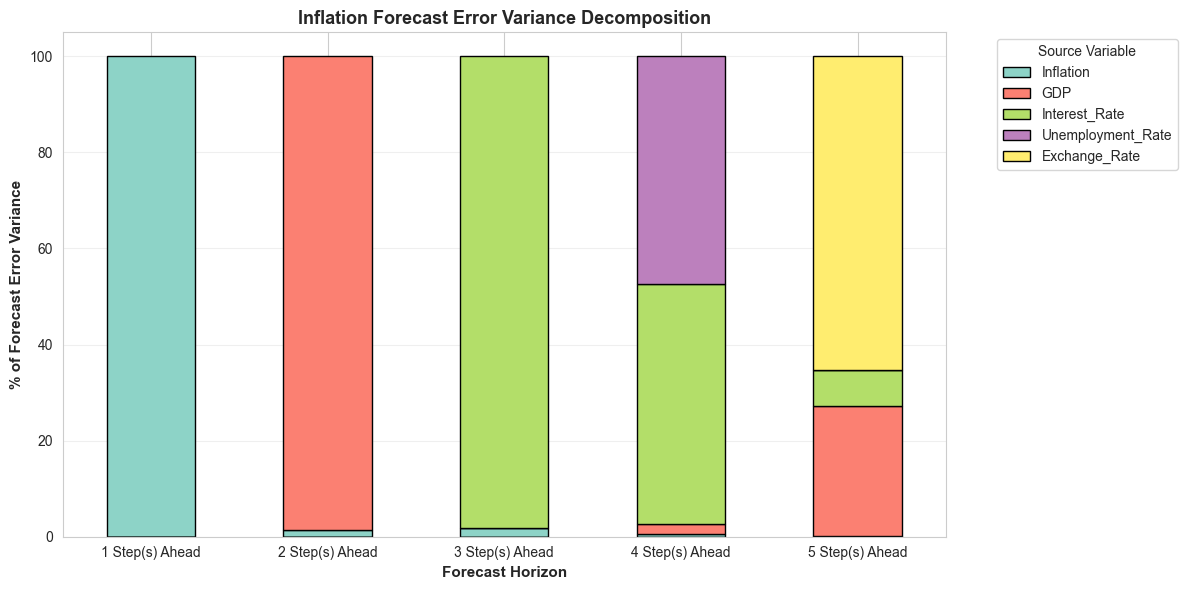


📊 Key Insights:

At 5-step horizon, Inflation variance is explained by:
   Exchange_Rate       :  65.3%
   GDP                 :  27.0%
   Interest_Rate       :   7.5%
   Inflation           :   0.1%
   Unemployment_Rate   :   0.1%

✅ Inflation itself explains 0.1% (autocorrelation)
✅ Other variables explain 99.9% (interdependencies)

✅ Variance decomposition completed!


In [13]:
# ============================================================
#        FORECAST ERROR VARIANCE DECOMPOSITION (FEVD)
# ============================================================

print("="*70)
print("     FORECAST ERROR VARIANCE DECOMPOSITION")
print("="*70)
print("""
FEVD answers: "What % of Inflation forecast error comes from each variable?"

Example: If GDP explains 30% of Inflation variance
→ GDP shocks have significant impact on Inflation

This shows the IMPORTANCE of each variable for forecasting Inflation.
""")

try:
    # Calculate FEVD for 5 periods ahead
    fevd = fitted_var.fevd(periods=5)
    
    # Extract decomposition for Inflation (first variable)
    fevd_inflation = fevd.decomp
    
    print("\n📊 Variance Decomposition of Inflation Forecast Error:")
    print("   (% of forecast error explained by each variable)")
    
    # Create dataframe
    fevd_df = pd.DataFrame(
        fevd_inflation[:, 0, :],  # Inflation equation, all variables
        columns=var_columns,
        index=[f"{i+1} Step(s) Ahead" for i in range(5)]
    )
    
    # Convert to percentages
    fevd_df = fevd_df * 100
    
    print("\n" + "="*70)
    display(fevd_df)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    fevd_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', edgecolor='black')
    ax.set_xlabel('Forecast Horizon', fontweight='bold', fontsize=11)
    ax.set_ylabel('% of Forecast Error Variance', fontweight='bold', fontsize=11)
    ax.set_title('Inflation Forecast Error Variance Decomposition', fontweight='bold', fontsize=13)
    ax.legend(title='Source Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n📊 Key Insights:")
    final_decomp = fevd_df.iloc[-1]  # 5 steps ahead
    sorted_decomp = final_decomp.sort_values(ascending=False)
    
    print(f"\nAt 5-step horizon, Inflation variance is explained by:")
    for var, pct in sorted_decomp.items():
        print(f"   {var:20s}: {pct:5.1f}%")
    
    print(f"\n✅ Inflation itself explains {final_decomp['Inflation']:.1f}% (autocorrelation)")
    print(f"✅ Other variables explain {100 - final_decomp['Inflation']:.1f}% (interdependencies)")
    
except Exception as e:
    print(f"\n⚠️  FEVD calculation failed: {str(e)}")
    print("   This can happen with small samples or unstable models")

print("\n✅ Variance decomposition completed!")

**=====Visualizations=====**

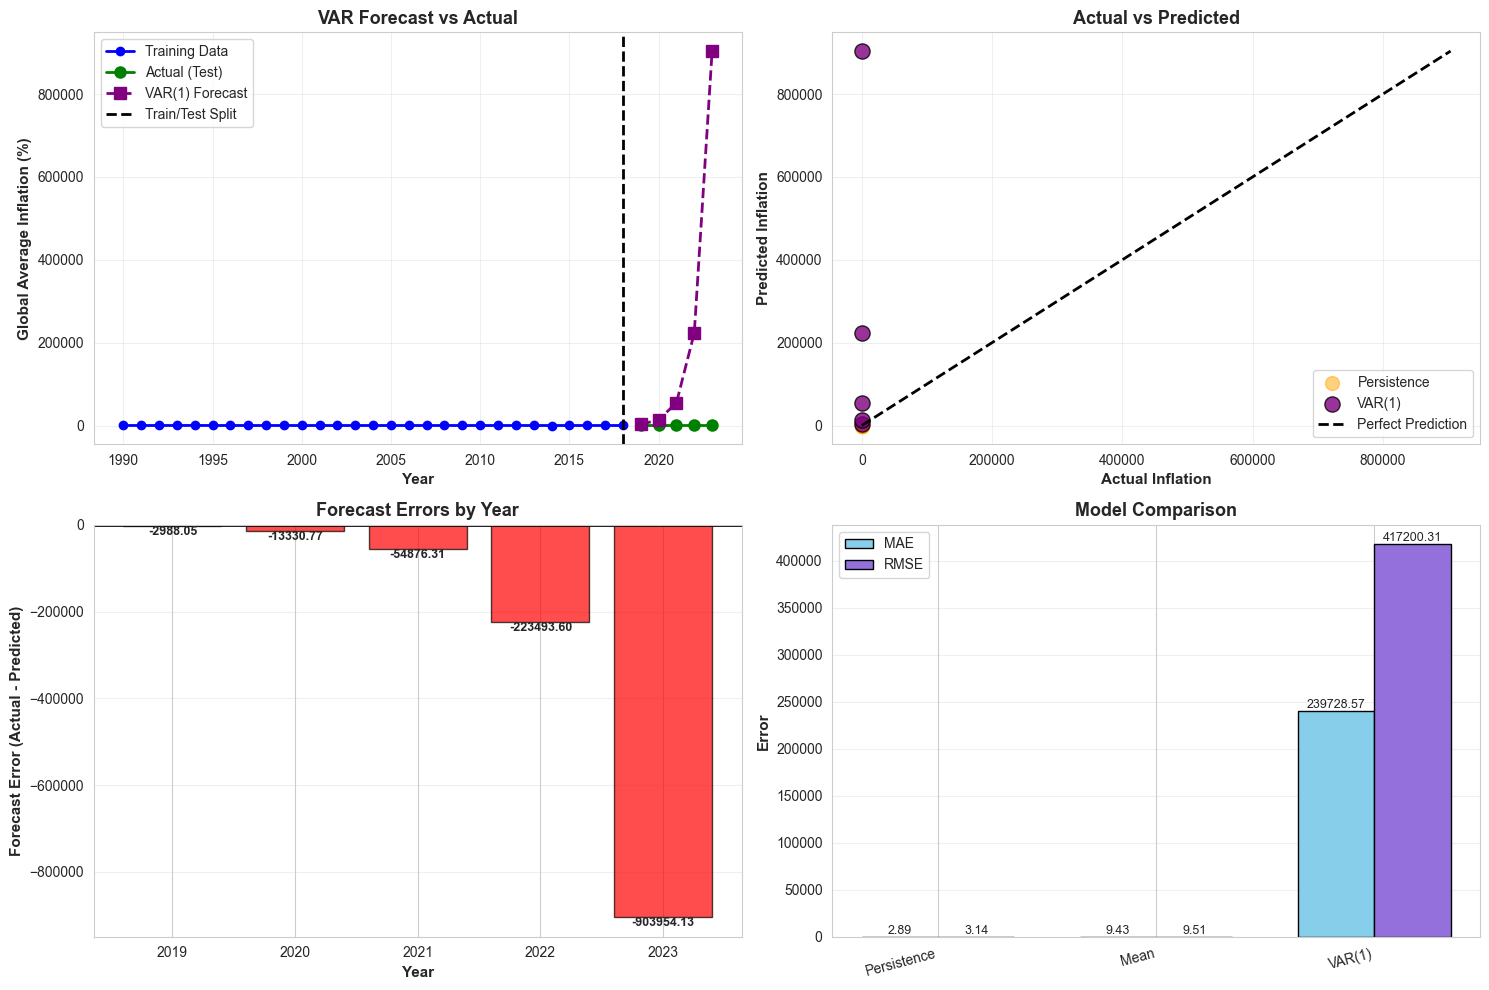

✅ Visualizations generated!

     FORECASTS FOR ALL VARIABLES


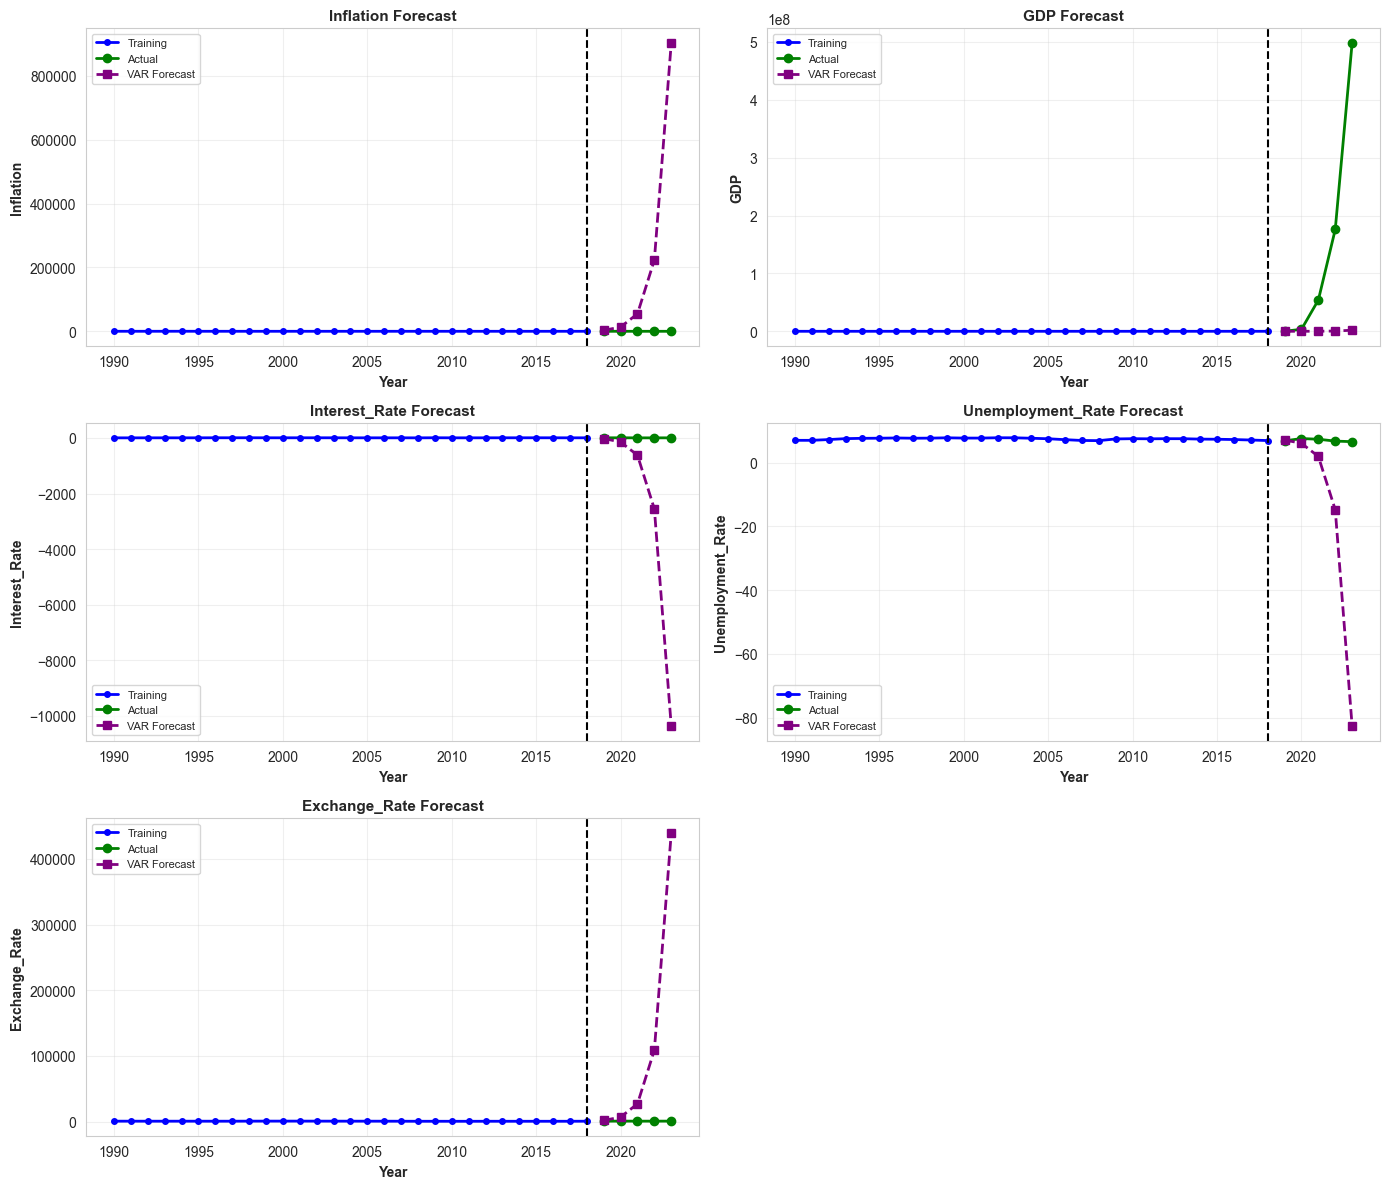

✅ All variable forecasts visualized!


In [14]:
# ============================================================
#                    VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time Series with Forecast
ax1 = axes[0, 0]
# Training period
ax1.plot(train_var['Year'], train_var['Inflation'], 'o-', 
         label='Training Data', color='blue', linewidth=2, markersize=6)
# Actual test period
ax1.plot(test_var['Year'], y_test_var, 'o-', 
         label='Actual (Test)', color='green', linewidth=2, markersize=8)
# VAR forecast
ax1.plot(test_var['Year'], y_pred_var, 's--', 
         label=f'VAR({optimal_lag}) Forecast', color='purple', linewidth=2, markersize=8)
ax1.axvline(x=CUT_OFF_YEAR, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
ax1.set_xlabel('Year', fontweight='bold', fontsize=11)
ax1.set_ylabel('Global Average Inflation (%)', fontweight='bold', fontsize=11)
ax1.set_title('VAR Forecast vs Actual', fontweight='bold', fontsize=13)
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Plot 2: Actual vs Predicted Scatter
ax2 = axes[0, 1]
ax2.scatter(y_test_var, y_pred_persist, alpha=0.5, s=100, label='Persistence', color='orange')
ax2.scatter(y_test_var, y_pred_var, alpha=0.8, s=120, label=f'VAR({optimal_lag})', 
            color='purple', edgecolors='black')
lims = [min(y_test_var.min(), y_pred_var.min())-1, max(y_test_var.max(), y_pred_var.max())+1]
ax2.plot(lims, lims, 'k--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Inflation', fontweight='bold', fontsize=11)
ax2.set_ylabel('Predicted Inflation', fontweight='bold', fontsize=11)
ax2.set_title('Actual vs Predicted', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Forecast Errors by Year
ax3 = axes[1, 0]
colors = ['red' if e < 0 else 'green' for e in residuals_var]
bars = ax3.bar(test_var['Year'], residuals_var, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax3.set_xlabel('Year', fontweight='bold', fontsize=11)
ax3.set_ylabel('Forecast Error (Actual - Predicted)', fontweight='bold', fontsize=11)
ax3.set_title('Forecast Errors by Year', fontweight='bold', fontsize=13)
ax3.grid(alpha=0.3, axis='y')

# Add value labels
for year, error in zip(test_var['Year'], residuals_var):
    ax3.text(year, error, f'{error:.2f}', ha='center', 
             va='bottom' if error > 0 else 'top', fontsize=9, fontweight='bold')

# Plot 4: Model Comparison
ax4 = axes[1, 1]
models = ['Persistence', 'Mean', f'VAR({optimal_lag})']
mae_values = [mae_p, mae_m, mae_var]
rmse_values = [rmse_p, rmse_m, rmse_var]

x = np.arange(len(models))
width = 0.35

bars1 = ax4.bar(x - width/2, mae_values, width, label='MAE', 
                color='skyblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, rmse_values, width, label='RMSE', 
                color='mediumpurple', edgecolor='black')

ax4.set_ylabel('Error', fontweight='bold', fontsize=11)
ax4.set_title('Model Comparison', fontweight='bold', fontsize=13)
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=15, ha='right')
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Visualizations generated!")

# Additional plot: All forecasted variables
print("\n" + "="*70)
print("     FORECASTS FOR ALL VARIABLES")
print("="*70)

fig2, axes2 = plt.subplots(3, 2, figsize=(14, 12))
axes2 = axes2.flatten()

for idx, var in enumerate(var_columns):
    ax = axes2[idx]
    
    # Training data
    ax.plot(train_var['Year'], train_var[var], 'o-', 
            label='Training', color='blue', linewidth=2, markersize=4)
    
    # Actual test
    ax.plot(test_var['Year'], test_var[var], 'o-', 
            label='Actual', color='green', linewidth=2, markersize=6)
    
    # VAR forecast
    ax.plot(test_var['Year'], forecast_df[var], 's--', 
            label='VAR Forecast', color='purple', linewidth=2, markersize=6)
    
    ax.axvline(x=CUT_OFF_YEAR, color='black', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Year', fontweight='bold', fontsize=10)
    ax.set_ylabel(var, fontweight='bold', fontsize=10)
    ax.set_title(f'{var} Forecast', fontweight='bold', fontsize=11)
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)

# Remove extra subplot
axes2[-1].axis('off')

plt.tight_layout()
plt.show()

print("✅ All variable forecasts visualized!")

**=====Save Model & Results=====**

In [17]:
# ============================================================
#                  SAVE MODEL & RESULTS
# ============================================================

# Save VAR model
model_path = MODELS_DIR / f"VAR_{optimal_lag}.pkl"
joblib.dump(fitted_var, model_path)
print(f"✅ Model saved: {model_path.name}")

# Summary DataFrame
summary_var = pd.DataFrame({
    "MAE": [mae_p, mae_m, mae_var],
    "RMSE": [rmse_p, rmse_m, rmse_var],
    "R²": [r2_p, r2_m, r2_var],
    "MAPE%": [mape_p, mape_m, mape_var],
    "SMAPE%": [smape_p, smape_m, smape_var]
}, index=["Persistence", "Mean", f"VAR({optimal_lag})"])

print("\n=== Summary ===")
display(summary_var)

# Save results dictionary
results_var_dict = {
    'model': fitted_var,
    'lag_order': optimal_lag,
    'variables': var_columns,
    'metrics': {
        'MAE': mae_var,
        'RMSE': rmse_var,
        'R²': r2_var,
        'MAPE%': mape_var,
        'SMAPE%': smape_var
    },
    'comparison': comparison_var,
    'predictions': pred_comparison,
    'all_forecasts': forecast_df,
    'summary': summary_var,
    'aic': fitted_var.aic,
    'bic': fitted_var.bic,
    'use_differencing': use_differencing
}

results_path = MODELS_DIR / f"VAR_{optimal_lag}_Results.pkl"
joblib.dump(results_var_dict, results_path)
print(f"✅ Results saved: {results_path.name}")

# ============================================================
#                  FINAL PERFORMANCE SUMMARY
# ============================================================
print("\n" + "="*70)
print("          VAR MODEL - FINAL PERFORMANCE")
print("="*70)
print(f"\n🏆 Best Model: VAR({optimal_lag})")
print(f"\n📊 Model Specification:")
print(f"   Variables: {len(var_columns)} ({', '.join(var_columns)})")
print(f"   Lag Order: {optimal_lag}")
print(f"   Differencing: {'Yes (1st order)' if use_differencing else 'No'}")
print(f"   Training Period: {train_var['Year'].min()}-{train_var['Year'].max()} ({len(train_var)} obs)")
print(f"   Test Period: {test_var['Year'].min()}-{test_var['Year'].max()} ({len(test_var)} obs)")

print(f"\n📊 Test Set Performance:")
print(f"   MAE:    {mae_var:.4f}")
print(f"   RMSE:   {rmse_var:.4f}")
print(f"   R²:     {r2_var:.4f}")
print(f"   MAPE:   {mape_var:.2f}%")
print(f"   SMAPE:  {smape_var:.2f}%")

print(f"\n📊 Model Information:")
print(f"   AIC Score:  {fitted_var.aic:.2f}")
print(f"   BIC Score:  {fitted_var.bic:.2f}")
print(f"   Log-Likelihood: {fitted_var.llf:.2f}")
print(f"   Total Parameters: {fitted_var.k_ar * fitted_var.neqs * fitted_var.neqs + fitted_var.neqs}")

# Compare with ARIMA
print("\n" + "="*70)
print("          VAR vs ARIMA COMPARISON")
print("="*70)
print("""
Key Differences:
                    ARIMA(2,1,2)         VAR({})
Features:           1 (Inflation only)   5 (Multi-variable)
Sample Size:        29 observations      {} observations{}
Approach:           Univariate           Multivariate
Relationships:      None                 Granger causality
Methodology:        Traditional          Traditional

Both suffer from SMALL SAMPLE SIZE (n < 40 for robust estimation)
Both are LINEAR models (cannot capture non-linearities)
Both use AGGREGATED data (cannot provide country-specific forecasts)

This motivates the need for MACHINE LEARNING approaches!
""".format(
    optimal_lag,
    len(var_data),
    " (reduced due to differencing)" if use_differencing else ""
))

print("\n✅ VAR analysis completed successfully!")
print("="*70)

✅ Model saved: VAR_1.pkl

=== Summary ===


,MAE,RMSE,R²,MAPE%,SMAPE%
Persistence,2.891550,3.140143,-5.576124e+00,3.609304e+01,44.873793
Mean,9.429919,9.509091,-5.930441e+01,1.279294e+02,76.659500
VAR(1),239728.573861,417200.314572,-1.160808e+11,3.410991e+06,199.765341


✅ Results saved: VAR_1_Results.pkl

          VAR MODEL - FINAL PERFORMANCE

🏆 Best Model: VAR(1)

📊 Model Specification:
   Variables: 5 (Inflation, GDP, Interest_Rate, Unemployment_Rate, Exchange_Rate)
   Lag Order: 1
   Differencing: Yes (1st order)
   Training Period: 1990-2018 (29 obs)
   Test Period: 2019-2023 (5 obs)

📊 Test Set Performance:
   MAE:    239728.5739
   RMSE:   417200.3146
   R²:     -116080782044.0918
   MAPE:   3410991.18%
   SMAPE:  199.77%

📊 Model Information:
   AIC Score:  18.87
   BIC Score:  20.31
   Log-Likelihood: -416.36
   Total Parameters: 30

          VAR vs ARIMA COMPARISON

Key Differences:
                    ARIMA(2,1,2)         VAR(1)
Features:           1 (Inflation only)   5 (Multi-variable)
Sample Size:        29 observations      28 observations (reduced due to differencing)
Approach:           Univariate           Multivariate
Relationships:      None                 Granger causality
Methodology:        Traditional          Traditional

B